<a href="https://colab.research.google.com/github/mcvlix/lorenz-96-hybrid-esn/blob/main/hybrid_rcesn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Mount your Drive ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# === Libraries ===
import sys
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tqdm import tqdm
from tqdm import trange
import torch
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse import linalg
from pathlib import Path
import gc
import pickle

In [ ]:
# === Paths ===
project_path = '/content/drive/My Drive/AM170B Project'
data_path = os.path.join(project_path, 'data')
states_path = os.path.join(project_path, 'hybrid_states')
checkpoints_path = os.path.join(project_path, 'checkpoints')
models_path = os.path.join(project_path, 'models')
runs_path = os.path.join(project_path, 'runs')
predictions_path = os.path.join(project_path, 'predictions')
plots_path = os.path.join(project_path, 'plots')
os.makedirs(states_path, exist_ok=True)
os.makedirs(checkpoints_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)
os.makedirs(predictions_path, exist_ok=True)
os.makedirs(plots_path, exist_ok=True)

In [ ]:
os.listdir(project_path)

['data',
 'checkpoints',
 'states',
 'models',
 'old_rcesn.ipynb',
 'predictions',
 'plots',
 'hybrid_states',
 'runs',
 'old_hybrid_rcesn.ipynb',
 'enkf.ipynb',
 'Test.ipynb',
 'Data.ipynb',
 'rcesn.ipynb',
 'hybrid_rcesn.ipynb',
 'main.ipynb']

In [ ]:
# === View Memory Usage ===
def whos_memory(namespace):
    exclude = {
        'np', 'pd', 'plt', 'os', 'gc', 'sys', 'sio', 'tqdm', 'torch', 'sparse', 'Path',
        'exit', 'quit', 'open', 'get_ipython', 'whos_memory'
    }
    print(f"{'Variable':20} {'Type':15} {'Size (MB)':>10}")
    print("-" * 50)
    for name, val in namespace.items():
        if name.startswith("_") or name in exclude:
            continue
        try:
            size = sys.getsizeof(val) / 1024 / 1024
            print(f"{name:20} {type(val).__name__:15} {size:10.4f}")
        except Exception:
            print(f"{name:20} {type(val).__name__:15} {'<unknown>'}")

# del
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0001
Out                  dict                0.0002
drive                module              0.0001
cp                   module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
runs_path            str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001


### Plotting Function

In [ ]:
def plot_model_vs_truth(X_true, X_model, start=0, model_name="Model", valid_time=None):
    """
    Plot true vs. model predictions and difference. Shows valid time if given.
    Inputs:
    - X_true, X_model: shape (K, T)
    - start: starting timestep for title and valid_time offset
    - valid_time: int, the timestep (relative to 0) when NRMSE exceeds threshold
    """
    X_diff = X_true - X_model
    T = X_true.shape[1]
    time_axis = np.arange(T)  # Aligned x-axis: always 0 to T-1
    space_axis = np.arange(X_true.shape[0])

    fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

    # === 1. Ground Truth ===
    c1 = axs[0].contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[0].set_title(f"True $X_k$ (from timestep {start})")
    axs[0].set_ylabel("$X_k$")
    axs[0].set_yticks(space_axis)
    axs[0].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c1, ax=axs[0], ticks=[-2, 0, 2])

    # === 2. Model Prediction ===
    c2 = axs[1].contourf(time_axis, space_axis, X_model, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[1].set_title(f"{model_name} $X_k$")
    axs[1].set_ylabel("$X_k$")
    axs[1].set_yticks(space_axis)
    axs[1].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c2, ax=axs[1], ticks=[-2, 0, 2])

    # === 3. Difference Plot ===
    c3 = axs[2].contourf(time_axis, space_axis, X_diff, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[2].set_title("Difference: $X_{\\text{true}} - X_{\\text{model}}$")
    axs[2].set_xlabel("Timesteps")
    axs[2].set_ylabel("$X_k$")
    axs[2].set_yticks(space_axis)
    axs[2].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c3, ax=axs[2], ticks=[-2, 0, 2])

    # === Add Valid Time Line ===
    if valid_time is not None:
        axs[2].axvline(x=valid_time, color='black', linestyle='--', linewidth=1.5, label=f"Valid time: t = {valid_time}")
        axs[2].legend(loc='upper right')
        axs[2].set_xticks(list(axs[2].get_xticks()) + [valid_time])

    plt.tight_layout()
    plt.show()


### ESN Parameters

In [ ]:
# === Parameters ===
shift_k = 0  # Start index for initial condition
approx_res_size = 5000

model_params = {
    'tau': 0.25,
    'nstep': 1000,
    'N': 144, # 72 from model, 72 from data
    'd': 22
}

res_params = {
    'radius': 0.1,
    'degree': 3,
    'sigma': 0.5,
    'train_length': 500000,
    'N': int(np.floor(approx_res_size / model_params['N']) * model_params['N']),
    'num_inputs': model_params['N'],
    'predict_length': 1000,
    'beta': 0.0001
}

### Imperfect Model

In [ ]:
# === Constants ===
K = 8
J = 8
F = 20
h=.5
c = 8
b = 10
dt = 0.005
T = 500000

# === Imperfect Step Function (Z excluded) ===
def x_der(x_vec, y_mat):
    y_avg = np.sum(y_mat, 0).squeeze()
    minus = [-1, 0, 1, 2, 3, 4, 5, 6]
    minus2 = [-2, -1, 0, 1, 2, 3, 4, 5]
    plus = [1, 2, 3, 4, 5, 6, 7, 0]

    x_minus = x_vec[minus]
    x_minus2 = x_vec[minus2]
    x_plus = x_vec[plus]

    dx = x_minus * (x_plus - x_minus2) - x_vec + F - (h * c / b) * y_avg
    return dx

def y_der(x_vec, y_mat):
  minus = [-1, 0, 1, 2, 3, 4, 5, 6]
  plus = [1, 2, 3, 4, 5, 6, 7, 0]
  plus2 = [2, 3, 4, 5, 6, 7, 0, 1]

  y_minus = y_mat[minus, :]
  y_plus = y_mat[plus, :]
  y_plus2 = y_mat[plus2, :]

  dy = -c * b * y_plus * (y_plus2 - y_minus) - c * y_mat + (h * c / b) * x_vec
  return dy


def x_step(x_vec, y_mat, dt_x):
    dx1 = x_der(x_vec, y_mat)
    dy1 = y_der(x_vec, y_mat)

    x_vec2 = x_vec + .5 * dt_x * dx1
    y_mat2 = y_mat + .5 * dt_x * dy1

    dx2 = x_der(x_vec2, y_mat)
    dy2 = y_der(x_vec2, y_mat2)

    x_vec3 = x_vec + .5 * dt_x * dx2
    y_mat3 = y_mat + .5 * dt_x * dy2

    dx3 = x_der(x_vec3, y_mat)
    dy3 = y_der(x_vec3, y_mat3)

    x_vec4 = x_vec + dt_x * dx3
    y_mat4 = y_mat + dt_x * dy3

    dx4 = x_der(x_vec4, y_mat)
    dy4 = y_der(x_vec4, y_mat4)

    x_vec = x_vec + dt_x / 6 * (dx1 + 2 * dx2 + 2 * dx3 + dx4)
    y_mat = y_mat + dt_x / 6 * (dy1 + 2 * dy2 + 2 * dy3 + dy4)

    return x_vec,y_mat

def imperfect_model(x_norm, y_norm, x_mean, x_std, y_mean, y_std, dt):
    """
    Propagates one timestep using the imperfect model in real space.
    """
    # Denormalize
    x_real = x_norm * x_std + x_mean
    y_real = y_norm * y_std + y_mean

    # Propagate in real space
    x_next_real, y_next_real = x_step(x_real, y_real, dt)

    # Re-normalize
    x_next_norm = (x_next_real - x_mean) / x_std
    y_next_norm = (y_next_real - y_mean) / y_std

    return x_next_norm, y_next_norm

In [ ]:
# === Load True Data and Normalization Constants ===
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
data = np.load(npy_path, mmap_mode='r')   # shape: (T, 72)
T = 500000                  # generate 500000 timesteps
print(f"Generating XY_model to match {T} timesteps")

# === Load Normalization Constants ===
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']
y_mean, y_std = norms['y_mean'], norms['y_std']

# === Allocate
XY_model = np.zeros((T, K + J * K))  # shape: (T, 72)

# === Generate Aligned X_model with Imperfect Model
for t in tqdm(range(T - 1), desc="Generating aligned XY_model"):
    # Get normalized input
    x_now_norm = data[t, :K]
    y_now_norm = data[t, K:].reshape(J, K, order='F')

    # Use imperfect model to get next step prediction
    x_next_norm, y_next_norm = imperfect_model(x_now_norm, y_now_norm, x_mean, x_std, y_mean, y_std, dt)

    # Save aligned prediction
    XY_model[t, :K] = x_next_norm
    XY_model[t, K:] = y_next_norm.flatten(order='F')  # reshape to 1D row-major

# === Save to .npy for mmap use
save_path = os.path.join(data_path, 'XY_model_full.npy')
np.save(save_path, XY_model)
print(f"Saved XY_model to {save_path}")

# # === For each t in 0...(T-1), generate K[X_true[t]] and align it with X_true[t]
# for t in tqdm(range(T - 1), desc="Generating aligned X_model"):
#     X_now = data[t, :K] * 6.7887 + 3.5303
#     Y_now = data[t, K:].reshape(J, K, order='F') * 0.3608 + 0.1262
#     X_pred, _ = x_step(X_now, Y_now, dt)
#     X_model[t] = X_pred

# # === Save to .npz ===
# save_path = os.path.join(data_path, 'X_model_full.npz')
# np.savez_compressed(save_path, X_model=X_model)
# print(f"Saved X_model to {save_path}")

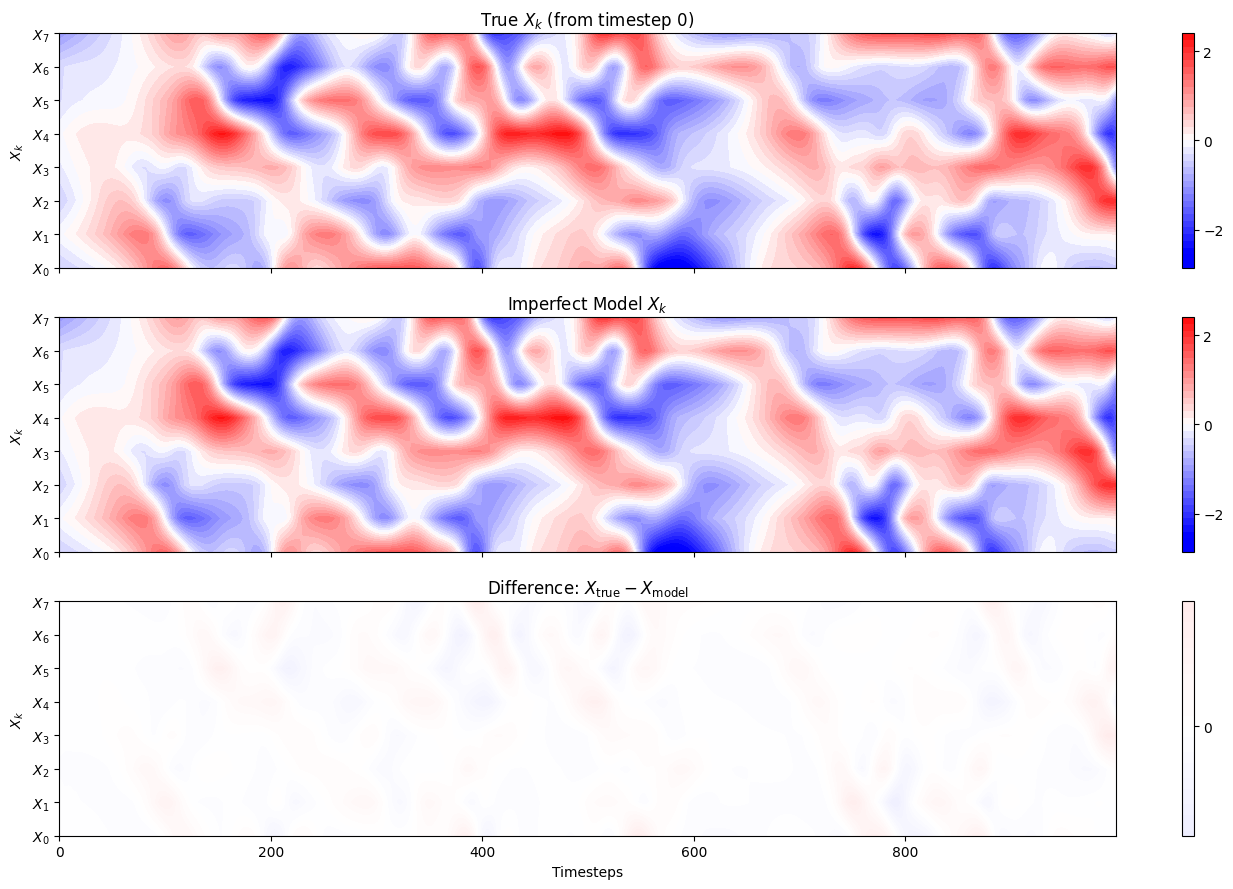

In [ ]:
# Safe range for final 1000 steps (T = 500000)
start_idx = 0
end_idx = 1000

# === Load X_model from XY_model_full.npy
XY_model = np.load(os.path.join(data_path, 'XY_model_full.npy'), mmap_mode='r')
X_model = XY_model[start_idx:end_idx, :8].T  # shape: (8, 1000)

# === Load X_true from original ground-truth file
X_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')[start_idx:end_idx, :8].T  # shape: (8, 1000)

# === Plot
plot_model_vs_truth(X_true, X_model, start=start_idx, model_name="Imperfect Model", valid_time=None)

In [ ]:
T_pred = 1000
start_idx = 0  # Pick a point deep into data (adjust as needed)

# === Load true data for comparison ===
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
data = np.load(npy_path, mmap_mode='r')
X_true = data[start_idx:start_idx + T_pred, :K].T  # shape: (8, 1000)
Y_true = data[start_idx:start_idx + T_pred, K:].reshape(T_pred, J, K, order='F')

# === Initialize from true state ===
X_init = data[start_idx, :K]
Y_init = data[start_idx, K:].reshape(J, K, order='F')

100%|██████████| 1000/1000 [00:00<00:00, 6027.89it/s]


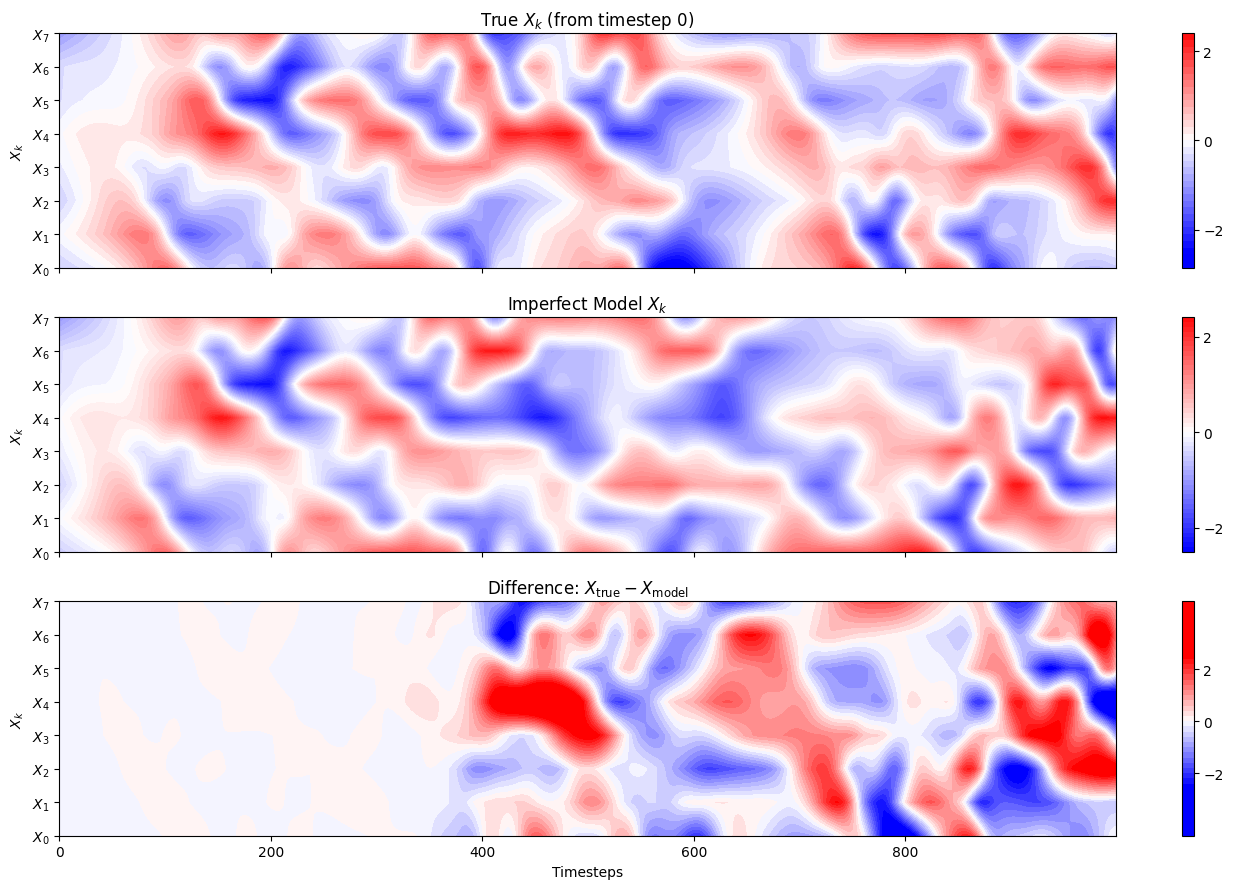

In [ ]:
X_model = np.zeros((K, T_pred))

x_norm = X_init.copy()
y_norm = Y_init.copy()
# === Load Normalization Constants ===
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']
y_mean, y_std = norms['y_mean'], norms['y_std']

# === Recursive Generation ===
for t in trange(T_pred):
    # Unscaled input version
    x_norm, y_norm = imperfect_model(x_norm, y_norm, x_mean, x_std, y_mean, y_std, dt)
    X_model[:, t] = x_norm

plot_model_vs_truth(X_true, X_model, start=0, model_name="Imperfect Model", valid_time=None)

In [ ]:
# === Free memory ===
del X_true, X_model
gc.collect()
whos_memory(globals())

### Utilities

In [ ]:
# === Utilities ===
def generate_reservoir(size, radius, degree):
    print("Generating Reservoir")
    sparsity = degree / float(size)
    A = sparse.rand(size, size, density=sparsity).todense()
    eigvals = np.linalg.eigvals(A)
    A = (A / np.max(np.abs(eigvals))) * radius
    return A

def build_input_weights(N, num_inputs, sigma):
    print("Building Input Weights")
    q = int(N / num_inputs)
    Win = np.zeros((N, num_inputs))
    for i in range(num_inputs):
        np.random.seed(i)
        Win[i * q: (i + 1) * q, i] = sigma * (-1 + 2 * np.random.rand(q))
    return Win

def reservoir_layer(A, Win, XY_true, XY_model, res_params, states=None):
    N = res_params['N']
    T = res_params['train_length']
    K = XY_true.shape[0]

    if states is None:
        states = np.zeros((N, T))

    for t in trange(1, T, desc="Loading Hybrid Reservoir with XY_true and XY_model"):
        # Hybrid input u(t) = [X_model[t], X_true[t]]
        xy_model_t = XY_model[:, t]  # shape (72,)
        xy_true_t = XY_true[:, t]    # shape (72,)
        u_t = np.hstack([xy_model_t, xy_true_t])  # shape (144,)
        states[:, t] = np.tanh(A @ states[:, t - 1] + Win @ u_t)

    return states

def train(res_params, r_states, X_model, X_true):
    beta = res_params['beta']
    N, T = r_states.shape
    K = X_model.shape[0]

    # === Transform r_states into r_star in-place
    r_star = r_states.copy()
    for j in trange(2, N - 2, desc="Transforming r_states → r* in-place"):
        if j % 2 == 0:
            r_star[j, :] = r_states[j - 1, :] * r_states[j - 2, :]

    # === Design matrix: [X_model; r*] shape → (K + N, T)
    X = np.vstack([X_model, r_star])  # (K + N, T)
    Y = X_true                          # (K, T)

    # === Tikhonov regularization (ridge regression)
    I = beta * np.identity(K + N)        # Dense identity matrix
    U = np.dot(X, X.T) + I
    W_out = np.dot(np.linalg.inv(U), np.dot(X, Y.T))  # (K + N, K)
    # W_out = np.linalg.solve(U, X @ Y.T)

    return W_out.T  # shape: (K, K + N)


def train_gpu(res_params, r_states, X_model, X_true):
    beta = res_params['beta']
    N, T = r_states.shape
    K = X_model.shape[0]  # Assuming shape (K, T)

    # === Convert to CuPy arrays
    r_states = cp.asarray(r_states)
    X_model = cp.asarray(X_model)
    X_true = cp.asarray(X_true)

    # === Transform r_states → r* in-place
    for j in trange(2, N - 2, desc="Transforming r_states → r* in-place (GPU)"):
        if j % 2 == 0:
            r_states[j, :] = r_states[j - 1, :] * r_states[j - 2, :]

    # === Stack input features: [X_model; r*] → (K + N, T)
    X = cp.vstack([X_model, r_states])
    Y = X_true

    # === Ridge Regression
    I = beta * cp.identity(K + N)
    U = X @ X.T + I
    # W_out = cp.dot(cp.linalg.inv(U), cp.dot(X, Y.T))
    W_out = cp.linalg.solve(U, X @ Y.T)  # (K + N, K)

    return cp.asnumpy(W_out.T)  # shape: (K, K + N)

### Load Reservoir States

In [ ]:
# === Generate Reservoir Matrices ===
A = generate_reservoir(res_params['N'], res_params['radius'], res_params['degree'])
Win = build_input_weights(res_params['N'], res_params['num_inputs'], res_params['sigma'])

Generating Reservoir
Building Input Weights


In [ ]:
# === Load True Data and Imperfect Model Data (0:500000) ===
start = 0
end = 500000

# Load true state X_true[t]
XY_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')[start:end].T  # (72, 500000)

# Load imperfect model prediction K[X_true[t-1]]
XY_model  = np.load(os.path.join(data_path, 'XY_model_full.npy'), mmap_mode='r')[start:end].T

In [ ]:
print("XY_true shape:    ", XY_true.shape)      # → (K, T)
print("XY_model shape:     ", XY_model.shape)       # → (K, T)

XY_true shape:     (72, 500000)
XY_model shape:      (72, 500000)


In [ ]:
# === Run reservoir layer using selected time window ===
r_states = reservoir_layer(A, Win, XY_true, XY_model, res_params)

Loading Hybrid Reservoir with XY_true and XY_model: 100%|██████████| 499999/499999 [1:02:30<00:00, 133.32it/s]


In [ ]:
print("r_states shape:   ", r_states.shape)     # → (N, T)

r_states shape:    (4896, 1000)


In [ ]:
# === Save as .npy for mmap_mode use
r_state_file_npy = os.path.join(states_path, 'r_states_hybrid')
np.save(r_state_file_npy, r_states)  # Will become 'r_states_hybrid.npy'

# === Save as .npz for backup/inspection
r_state_file_npz = os.path.join(states_path, 'r_states_hybrid_backup.npz')
np.savez_compressed(r_state_file_npz, r_states=r_states)

print(f"Saved reservoir states to:")
print(f" - {r_state_file_npy}.npy (for mmap)")
print(f" - {r_state_file_npz} (compressed backup)")
os.listdir(states_path)

In [ ]:
# === Save Checkpoint (A, Win)
checkpoint_file = os.path.join(checkpoints_path, 'hybrid_checkpoint_latest')
np.savez_compressed(checkpoint_file, A=A, Win=Win)
print(f"Saved A and Win to {checkpoint_file}")

Saved A and Win to /content/drive/My Drive/AM170B Project/checkpoints/hybrid_checkpoint_latest


In [ ]:
# === Optional: Free memory
del A, Win, XY_true, XY_model, r_states
gc.collect()
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
drive                module              0.0001
cp                   module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
runs_path            str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001
plot_model_vs_truth  function            0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict            

### Train Model

In [ ]:
train_length = 1000
res_params['train_length'] = train_length
r_states = np.load(os.path.join(states_path, 'r_states_hybrid.npy'), mmap_mode='r')[:, :train_length]
XY_model = np.load(os.path.join(data_path, 'XY_model_full.npy'), mmap_mode='r')[:train_length].T
XY_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')[:train_length, :72].T

In [ ]:
print("r_states shape:   ", r_states.shape)     # → (N, T)
print("XY_model shape:   ", XY_model.shape)     # → (72, T)
print("XY_true shape:    ", XY_true.shape)      # → (72, T)

r_states shape:    (4896, 1000)
XY_model shape:    (72, 1000)
XY_true shape:     (72, 1000)


In [ ]:
# Train output weights
# W_out = train_gpu(res_params, r_states, XY_model, XY_true)
W_out = train(res_params, r_states, XY_model, XY_true)

Transforming r_states → r* in-place: 100%|██████████| 4892/4892 [00:00<00:00, 94778.21it/s]


In [ ]:
# Save model components
checkpoint = np.load(os.path.join(checkpoints_path, f'hybrid_checkpoint_latest.npz'))
A = checkpoint['A']
Win = checkpoint['Win']

model_file = os.path.join(models_path, f'hybrid_model_{train_length}_xy.npz')
np.savez_compressed(model_file, A=A, Win=Win, W_out=W_out)

In [ ]:
del r_states, X_model, X_true
gc.collect()
# whos_memory(globals())

60

### Prediction

In [ ]:
# # Load final reservoir state
# r_state = np.load(os.path.join(states_path, 'r_states_hybrid.npz'))['r_states'][:, -1]
# r_idx = 500000          # Last time step of training
# start_idx = 500000      # First time step of prediction

# # Load initial condition from .npy file
# npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
# init = np.load(npy_path)[start_idx]
# X_init = init[:K]
# Y_init = init[K:].reshape(J, K)

In [ ]:
# Load model
model = np.load(os.path.join(models_path, 'hybrid_model_100000_xy.npz'))
A = model['A']
Win = model['Win']
W_out = model['W_out']

# Load final reservoir state
# r_state = np.zeros(res_params['N'])
r_idx = 100000          # Last time step of training
r_state = np.load(os.path.join(states_path, 'r_states_hybrid.npy'), mmap_mode = 'r')[:, r_idx]
# r_state = np.zeros(res_params['N'])
start_idx = 100000      # First time step of prediction

# # Load initial condition from .npy file
K_macro = 8
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
data = np.load(npy_path, mmap_mode='r')
X_init = data[start_idx, :K]
Y_init = data[start_idx, K:].reshape(J, K, order='F')

# === Load Normalization Constants ===
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']
y_mean, y_std = norms['y_mean'], norms['y_std']

# # === Prepare snapshot ===
# snapshot = {
#     'r_state': r_state,
#     'r_idx': r_idx,
#     'start_idx': start_idx,
#     'X_init': X_init,
#     'Y_init': Y_init
# }

# # === Save ===
# run_file = os.path.join(runs_path, f'run_{start_idx}_init.npz')
# np.savez_compressed(run_file, **snapshot)
# print(f"Saved run snapshot to {run_file}")

# # === Load run snapshot ===
# run_file = os.path.join(runs_path, 'run_500000_init.npz')
# run_data = np.load(run_file)

# r_state = run_data['r_state']
# r_idx = int(run_data['r_idx'])            # might be stored as float otherwise
# start_idx = int(run_data['start_idx'])
# X_init = run_data['X_init']
# Y_init = run_data['Y_init']

In [ ]:
r_state.shape, X_init.shape, Y_init.shape

((4896,), (8,), (8, 8))

In [ ]:
def predict_hybrid(A, Win, W_out, r_state, X_init, Y_init, res_params, r_idx, start_idx):
    print("Loading Constants")
    K = 72
    K_macro = 8
    J = 8
    N = res_params['N']
    T_pred = res_params['predict_length']
    dt = 0.005

    # === Allocate
    print("Allocating Memory")
    X_preds = np.zeros((K_macro, T_pred))
    Y_preds = np.zeros((J, K_macro, T_pred))  # 8 × 8 × T
    r = r_state.copy()
    X = X_init.copy()
    Y = Y_init.copy()

    # === Predict ===
    for t in tqdm(range(T_pred), desc="Hybrid Prediction"):
        X_model, Y_model = imperfect_model(X, Y, x_mean, x_std, y_mean, y_std, dt)
        XY_model = np.hstack([X_model, Y_model.flatten(order='F')])  # shape (72,)

        # Apply r* nonlinearity
        r_aug = r.copy()
        for j in range(2, N - 2):
            if j % 2 == 0:
                r_aug[j] = r[j - 1] * r[j - 2]

        # Form hybrid input
        hybrid_input = np.hstack([XY_model, r_aug])   # shape (72 + N,)

        # Predict next X and Y
        XY_pred = W_out @ hybrid_input                # shape (72,)

        X = XY_pred[:K_macro]
        Y = XY_pred[K_macro:].reshape(J, K_macro, order='F')

        # Store predictions
        X_preds[:, t] = X
        Y_preds[:, :, t] = Y

        # Update reservoir using predicted X and Y
        u = np.hstack([XY_model, XY_pred])
        r = np.tanh(A @ r + Win @ u)

    print("\n=== Shape Debug Info ===")
    print("X_preds shape:", X_preds.shape)      # (8, T)
    print("Y_preds shape:", Y_preds.shape)      # (8, 8, T)
    print("W_out shape  :", W_out.shape)
    print("==========================")

    return X_preds, Y_preds

In [ ]:
# === Run prediction ===
X_preds, Y_preds = predict_hybrid(
    A=A,
    Win=Win,
    W_out=W_out,
    r_state=r_state,
    X_init=X_init,
    Y_init=Y_init,
    res_params=res_params,
    r_idx=r_idx,
    start_idx=start_idx
)

Loading Constants
Allocating Memory


Hybrid Prediction: 100%|██████████| 1000/1000 [00:06<00:00, 153.39it/s]


=== Shape Debug Info ===
X_preds shape: (8, 1000)
Y_preds shape: (8, 8, 1000)
W_out shape  : (72, 4968)


In [ ]:
save_path = os.path.join(predictions_path, f"hybrid_preds_{start_idx}.npz")
np.savez_compressed(save_path, X_preds=X_preds, Y_preds=Y_preds)
print(f"Saved hybrid prediction to {save_path}")

Saved hybrid prediction to /content/drive/My Drive/AM170B Project/predictions/hybrid_preds_100000.npz


In [ ]:
del A, Win, W_out, X_init, Y_init, X_preds
gc.collect()

16296

### Plot Predictions

In [ ]:
# === Load predicted data ===
pred_file = os.path.join(predictions_path, f"hybrid_preds_{start_idx}.npz")
preds = np.load(pred_file)
X_pred = preds['X_preds']  # shape (8, T)

truth_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
X_true = np.load(truth_path, mmap_mode='r')[start_idx:start_idx + res_params['predict_length'], :K].T  # shape: (8, predict_length)

In [ ]:
X_pred.shape, X_true.shape

((8, 1000), (8, 1000))

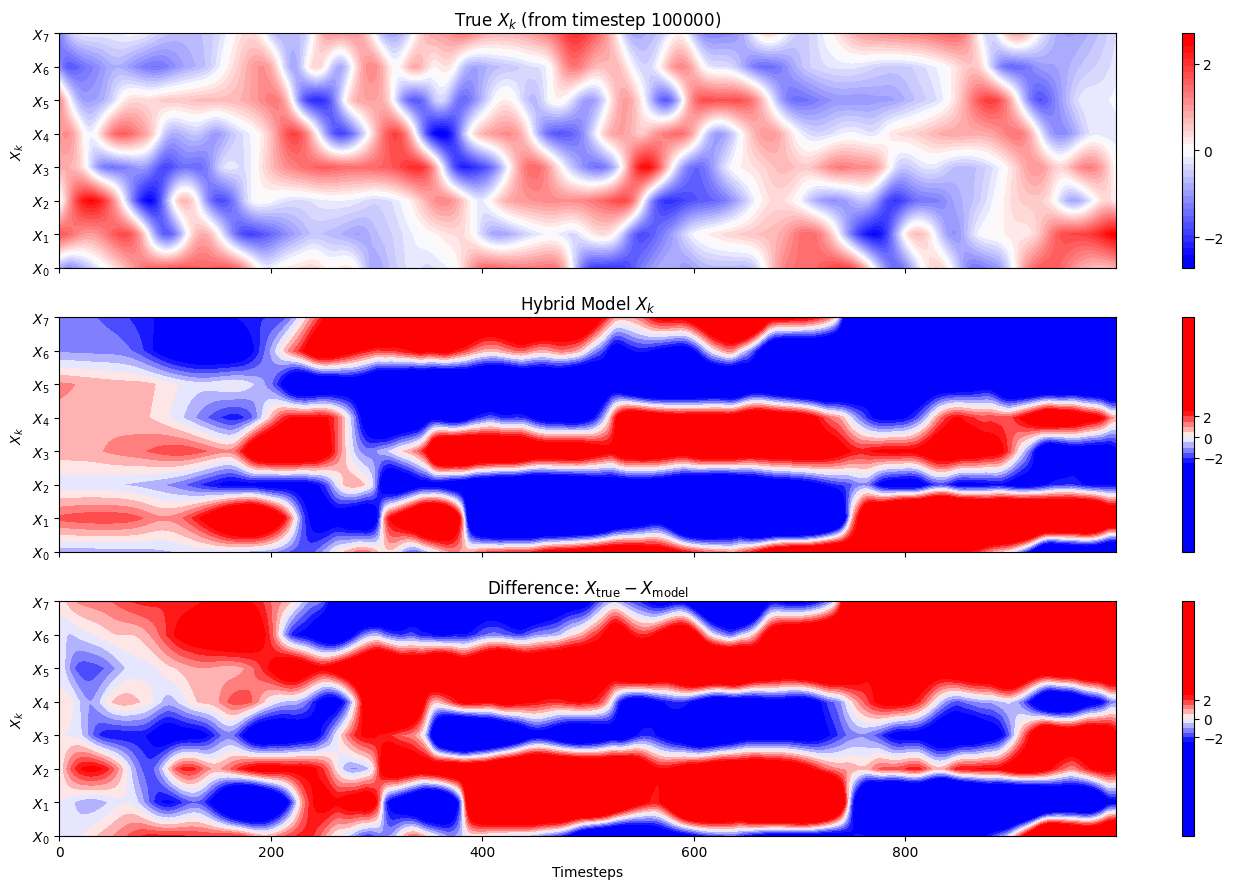

In [ ]:
# === Call the plotter ===
plot_model_vs_truth(X_true, X_pred, start=start_idx, model_name="Hybrid Model", valid_time=None)

### Prediction Test

In [ ]:
def predict_test(A, Win, W_out, r_state, XY_model, XY_true, res_params, start_idx=0):
    """
    Evaluates hybrid ESN on known XY data (no rollout). Returns predicted X only.

    Args:
        XY_model: (72, T)
        XY_true:  (72, T)
    """
    K_macro = 8
    K = 72
    J = 8
    N = res_params['N']
    T_eval = XY_model.shape[1]

    r = r_state.copy()
    X_preds = np.zeros((K_macro, T_eval))

    # === Initialize X, Y from XY_true at t=0 (only once)
    X = XY_true[:K_macro, 0]
    Y = XY_true[K_macro:, 0].reshape(J, K_macro, order='F')

    for t in tqdm(range(T_eval), desc="Rollout Prediction from Initial Condition"):
        # Step imperfect model to get [X_model, Y_model]
        X_model, Y_model = imperfect_model(X, Y, x_mean, x_std, y_mean, y_std, dt=0.005)
        XY_model_t = np.hstack([X_model, Y_model.flatten(order='F')])

        # r* transformation
        r_aug = r.copy()
        for j in range(2, N - 2):
            if j % 2 == 0:
                r_aug[j] = r[j - 1] * r[j - 2]

        # Predict
        hybrid_input = np.hstack([XY_model_t, r_aug])
        XY_pred = W_out @ hybrid_input
        X = XY_pred[:K_macro]
        Y = XY_pred[K_macro:].reshape(J, K_macro, order='F')

        # Save X
        X_preds[:, t] = X

        # Update reservoir using model + prediction
        u = np.hstack([XY_model_t, XY_pred])
        r = np.tanh(A @ r + Win @ u)

    return X_preds

In [ ]:
X = np.clip(X, x_mean - 3 * x_std, x_mean + 3 * x_std)
Y = np.clip(Y, y_mean - 3 * y_std, y_mean + 3 * y_std)

In [ ]:
# === Parameters ===
shift_k = 0  # Start index for initial condition
approx_res_size = 5000

model_params = {
    'tau': 0.25,
    'nstep': 1000,
    'N': 144, # 72 from model, 72 from data
    'd': 22
}

res_params = {
    'radius': 0.1,
    'degree': 3,
    'sigma': 0.5,
    'train_length': 500000,
    'N': int(np.floor(approx_res_size / model_params['N']) * model_params['N']),
    'num_inputs': model_params['N'],
    'predict_length': 1000,
    'beta': 0.0001
}

Rollout Prediction from Initial Condition: 100%|██████████| 1000/1000 [00:05<00:00, 173.54it/s]


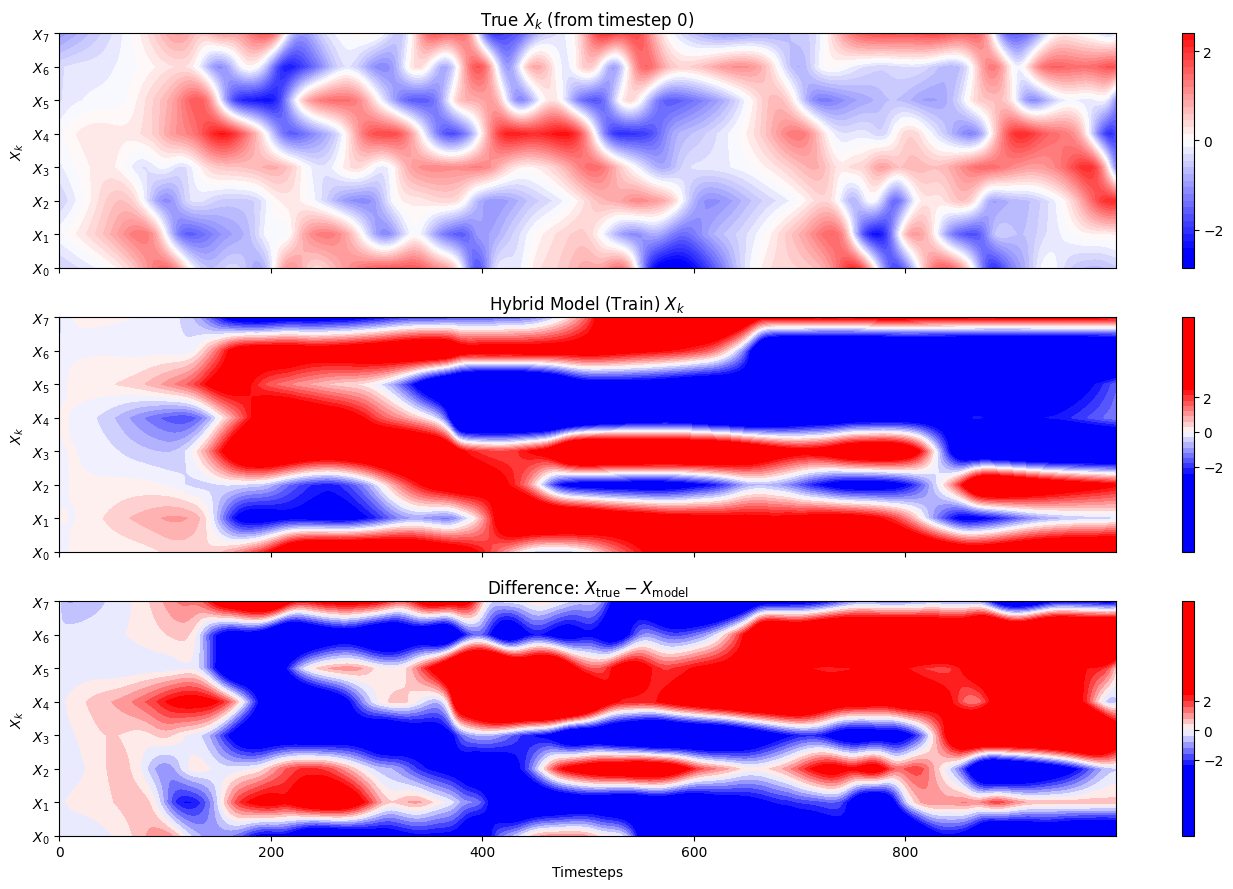

In [ ]:
# Load model
model = np.load(os.path.join(models_path, 'hybrid_model_10000_xy.npz'))
A = model['A']
Win = model['Win']
W_out = model['W_out']

# Load full XY_model and XY_true from disk
train_length = 1000
XY_model = np.load(os.path.join(data_path, 'XY_model_full.npy'), mmap_mode = 'r')[:train_length].T       # (72, 1000)
XY_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode = 'r')[:train_length, :72].T  # (72, 1000)

# Zero or known r_state
r_state = np.zeros(res_params['N'])

# Predict on training data
X_preds = predict_test(A, Win, W_out, r_state, XY_model, XY_true, res_params)

# Compare to true X
X_true = XY_true[:8, :]  # First 8 variables

# Plot
plot_model_vs_truth(X_true, X_preds, start=0, model_name="Hybrid Model (Train)", valid_time=None)

In [ ]:
# Load memory-mapped r_states
r_states_path = os.path.join(states_path, 'r_states_hybrid.npy')
r_states = np.load(r_states_path, mmap_mode='r')  # shape: (N, T)

# Access the first column
first_r = r_states[:, 0]  # shape: (N,)

# Check if it's all zeros
is_zero = np.allclose(first_r, 0.0)

print("First r_state is zero vector:", is_zero)
print("First r_state values:\n", first_r)

First r_state is zero vector: True
First r_state values:
 [0. 0. 0. ... 0. 0. 0.]


In [ ]:
def predict_esn_test(A, Win, W_out, r_state, X_true, res_params):
    """
    Test ESN by replaying r_state driven by X_true inputs.
    Args:
        A, Win, W_out: ESN model components
        r_state: initial reservoir state (can be zeros or r_states[:, 0])
        X_true: shape (K, T) where K = num_inputs, used for both driving and ground truth
        res_params: dict with 'N', 'num_inputs', 'predict_length'

    Returns:
        X_preds: shape (K, T)
    """
    N = res_params['N']
    K, T = X_true.shape

    r = r_state.copy()
    X_preds = np.zeros((K, T))

    for t in tqdm(range(T), desc="ESN Test (No Rollout)"):
        # Update reservoir with true input
        u = X_true[:, t]
        r = np.tanh(A @ r + Win @ u)

        # r* transformation
        r_star = r.copy()
        for j in range(2, N - 2):
            if j % 2 == 0:
                r_star[j] = r[j - 1] * r[j - 2]

        # Predict
        X_preds[:, t] = W_out @ r_star

    return X_preds


In [ ]:
# === Parameters ===
shift_k = 0  # Start index for initial condition
approx_res_size = 5000

model_params = {
    'tau': 0.25,
    'nstep': 1000,
    'N': 8,
    'd': 22
}

res_params = {
    'radius': 0.1,
    'degree': 3,
    'sigma': 0.5,
    'train_length': 500000,
    'N': int(np.floor(approx_res_size / model_params['N']) * model_params['N']),
    'num_inputs': model_params['N'],
    'predict_length': 1000,
    'beta': 0.0001
}

ESN Test (No Rollout): 100%|██████████| 1000/1000 [00:04<00:00, 217.54it/s]


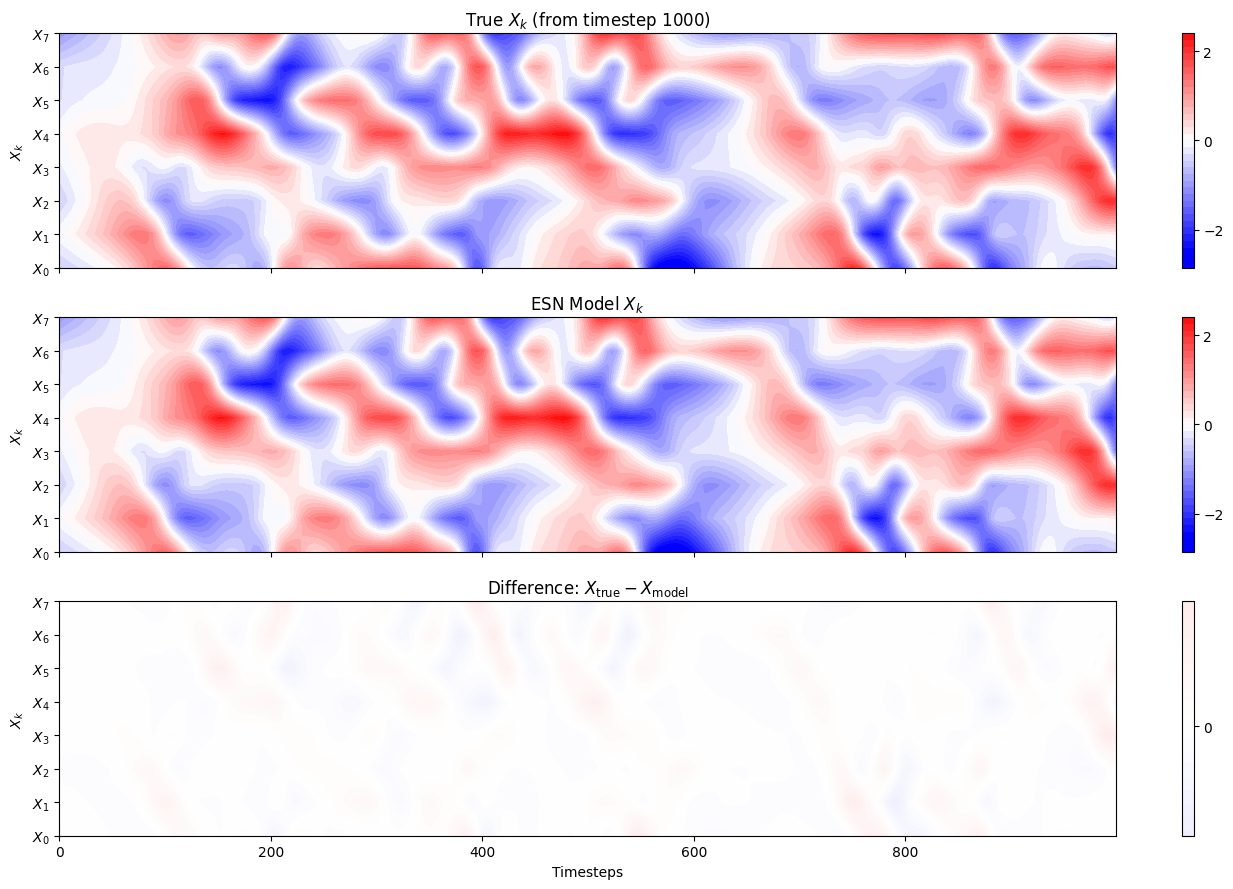

In [ ]:
# Load model
model = np.load(os.path.join(models_path, 'model_500000.npz'))
A = model['A']
Win = model['Win']
W_out = model['W_out']

# Set prediction length
res_params['predict_length'] = 1000

npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
data = np.load(npy_path, mmap_mode='r')   # shape: (T, 72)

# Load true data from t=0
X_true = np.load(npy_path, mmap_mode='r')[0:1000, :res_params['num_inputs']].T

# Start from cold reservoir (zeros)
r_state = np.zeros(res_params['N'])

# Run evaluation
X_preds = predict_esn_test(A, Win, W_out, r_state, X_true, res_params)

# Plot
plot_model_vs_truth(X_true, X_preds, start=1000, model_name="ESN Model", valid_time=None)

In [ ]:
def predict_esn_rollout(A, Win, W_out, r_state, X_init, res_params):
    """
    Rollout prediction using a vanilla ESN, starting from an initial input X_init.

    Args:
        A, Win, W_out: ESN model components
        r_state: initial reservoir state (shape: [N,])
        X_init: initial input (shape: [K,]), used for t=0
        res_params: dict with 'N', 'num_inputs', 'predict_length'

    Returns:
        X_preds: shape (K, T)
    """
    N = res_params['N']
    K = res_params['num_inputs']
    T = res_params['predict_length']

    r = r_state.copy()
    X_preds = np.zeros((K, T))
    X = X_init.copy()  # Start from the true initial condition

    for t in tqdm(range(T), desc="ESN Rollout"):
        # Update reservoir with current input
        r = np.tanh(A @ r + Win @ X)

        # r* transformation
        r_star = r.copy()
        for j in range(2, N - 2):
            if j % 2 == 0:
                r_star[j] = r[j - 1] * r[j - 2]

        # Predict next X
        X = W_out @ r_star
        X_preds[:, t] = X

    return X_preds


ESN Rollout: 100%|██████████| 1000/1000 [00:05<00:00, 187.86it/s]


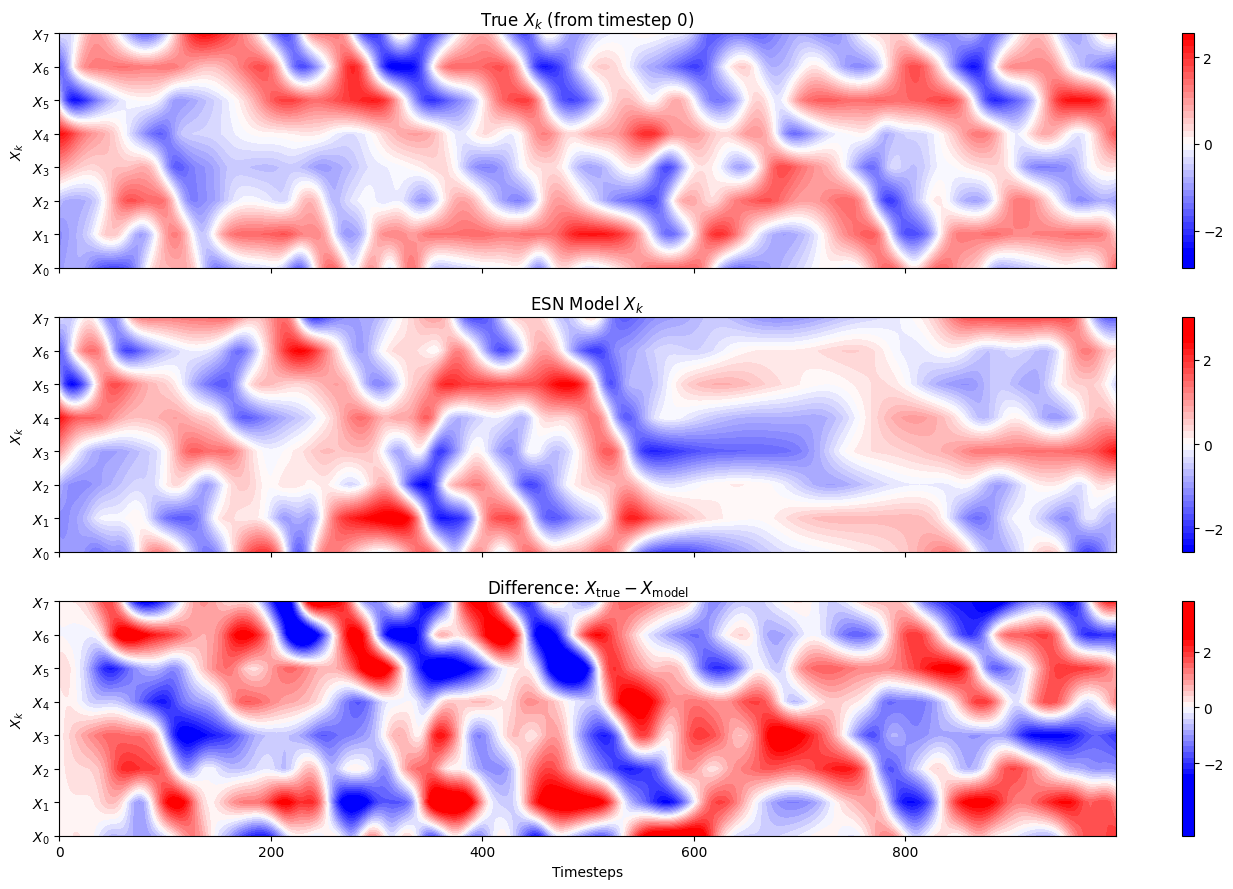

In [ ]:
# === Load Reservoir State at t = 500000 ===
states_path = os.path.join(project_path, 'states')
states_file = os.path.join(states_path, 'states_chunk_009.npz')
r_states = np.load(states_file)['states']  # shape: (N, T)
r_state = r_states[:, -1]

# === Load Initial Input X_init from t = 500000 ===
truth_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
X_init = np.load(truth_path, mmap_mode='r')[500000, :res_params['num_inputs']]

# === Predict Rollout ===
X_preds = predict_esn_rollout(A, Win, W_out, r_state, X_init, res_params)
X_true = np.load(truth_path, mmap_mode='r')[500000:500000 + res_params['predict_length'], :res_params['num_inputs']].T
plot_model_vs_truth(X_true, X_preds, start=0, model_name="ESN Model", valid_time=None)

### Test r_states alignment

In [ ]:
# === Load the reservoir states ===
r_states_path = os.path.join(states_path, 'r_states_hybrid.npz')
r_states = np.load(r_states_path)['r_states']  # shape: (N, T)

# === Check the first state ===
r0 = r_states[:, 0]

# === Print diagnostics ===
print("[Hybrid Reservoir Zero Check]")
print("Shape         :", r0.shape)
print("Max abs value :", np.max(np.abs(r0)))
print("Any nonzeros? :", not np.allclose(r0, 0))
print("r_states[:, 0][:10]:", r0[:10])  # show a preview

[Hybrid Reservoir Zero Check]
Shape         : (4992,)
Max abs value : 0.0
Any nonzeros? : False
r_states[:, 0][:10]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Test X_model Alignment

In [ ]:
t_test = 0

# Load X_true[t] and X_true[t+1]
data = np.load(npy_path, mmap_mode='r')
X_now = data[t_test, :K] * 6.7887 + 3.5303
Y_now = data[t_test, K:].reshape(J, K, order='F') * 0.3608 + 0.1262

# Run imperfect model step
X_pred, _ = x_step(X_now, Y_now, dt)

# Load stored X_model[t]
X_model = np.load(os.path.join(data_path, 'X_model_full.npz'))['X_model']
X_model_stored = X_model[t_test]  # Should match X_pred

# Load ground truth for X_true[t+1]
X_true_next = data[t_test + 1, :K] * 6.7887 + 3.5303

# === Check
print("X_model[0] (stored):", X_model_stored)
print("x_step(X_true[0])  :", X_pred)
print("X_true[1]          :", X_true_next)

# Error diagnostics
print("\n--- Differences ---")
print("Δ Stored vs Computed X_model:", np.abs(X_model_stored - X_pred))
print("Δ Model vs True Next X      :", np.abs(X_pred - X_true_next))


X_model[0] (stored): [ 0.35207551  3.26909637  0.48924615  2.32061724  3.29059298  1.35244576
  1.29440044 -3.35474275]
x_step(X_true[0])  : [ 0.35207551  3.26909637  0.48924615  2.32061724  3.29059298  1.35244576
  1.29440044 -3.35474275]
X_true[1]          : [ 0.34465711  3.25913251  0.48454069  2.31731996  3.28611591  1.34867004
  1.2969415  -3.36041317]

--- Differences ---
Δ Stored vs Computed X_model: [0. 0. 0. 0. 0. 0. 0. 0.]
Δ Model vs True Next X      : [0.0074184  0.00996386 0.00470547 0.00329728 0.00447708 0.00377572
 0.00254106 0.00567042]
